## Imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import files

## Data Loading

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

# Create Kaggle directory and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using the Kaggle API
!kaggle competitions download -c state-farm-distracted-driver-detection

import zipfile

# Unzip the downloaded dataset
with zipfile.ZipFile("state-farm-distracted-driver-detection.zip", "r") as zip_ref:
    zip_ref.extractall("state_farm_dataset")

Saving kaggle.json to kaggle.json
100% 4.00G/4.00G [03:01<00:00, 23.8MB/s]
100% 4.00G/4.00G [03:01<00:00, 23.7MB/s]


## Data Preprocessing

In [ ]:
# Path to the train folder
train_dir = "state_farm_dataset/imgs/train"  # Update this path to your dataset location

# Image dimensions
img_width, img_height = 64, 48

# Initialize lists for images and labels
images = []
labels = []

# List categories (subfolders)
categories = os.listdir(train_dir)

# Iterate over each category folder (e.g., 'c0', 'c1', etc.)
for category in categories:
    category_path = os.path.join(train_dir, category)

    # Only process subfolders (directories)
    if os.path.isdir(category_path):
        # Get all images in the current category
        for filename in os.listdir(category_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(category_path, filename)

                # Load the image
                img = load_img(img_path, target_size=(img_width, img_height))
                img_array = img_to_array(img)

                # Append the image and its label
                images.append(img_array)
                labels.append(int(category[1:]))  # Assumes categories are like 'c0', 'c1', ..., 'c9'

# Convert the list of images and labels to numpy arrays
x = np.array(images, dtype="float32")  # Shape: (num_images, 64, 48, 3)
y = np.array(labels, dtype="int32")  # Shape: (num_images,)

# Normalize pixel values to [0, 1]
x = x / 255.0

# Split the data into train, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Now we have:
# x_train, y_train: Training data
# x_val, y_val: Validation data
# x_test, y_test: Test data

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Build the CNN model
input_shape = (img_width, img_height, 3)

x_train shape: (17939, 64, 48, 3), y_train shape: (17939,)
x_val shape: (2242, 64, 48, 3), y_val shape: (2242,)
x_test shape: (2243, 64, 48, 3), y_test shape: (2243,)


## Model Building

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='selu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.27))

model.add(Conv2D(64, (3, 3), activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.27))

model.add(Conv2D(128, (3, 3), activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.27))

model.add(Conv2D(256, (3, 3), activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.27))

model.add(Flatten())
model.add(Dense(512, activation='selu'))
model.add(Dropout(0.27))
model.add(Dense(10, activation='softmax'))

# Compile the model
optimizer = AdamW(learning_rate=0.01, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.38, patience=4)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 62, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 62, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 31, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 31, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 29, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 29, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 14, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 14, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 8, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 12, 8, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 6, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 6, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 4, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 4, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 2, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 2, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 658,122 (2.51 MB)

 Trainable params: 657,162 (2.51 MB)

 Non-trainable params: 960 (3.75 KB)

## Training

Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.1966 - loss: 5.5418 - val_accuracy: 0.4853 - val_loss: 2.1640 - learning_rate: 0.0100
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6738 - loss: 1.1469 - val_accuracy: 0.6748 - val_loss: 2.0924 - learning_rate: 0.0100
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8220 - loss: 0.6956 - val_accuracy: 0.9376 - val_loss: 0.2438 - learning_rate: 0.0100
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8842 - loss: 0.4847 - val_accuracy: 0.9545 - val_loss: 0.1614 - learning_rate: 0.0100
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8831 - loss: 0.5689 - val_accuracy: 0.9505 - val_loss: 0.2421 - learning_rate: 0.0100
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8946 - loss: 0.5978 - val_accuracy: 0.9674 - val_loss: 0.1786 - learning_rate: 0.0100
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9254 - loss: 

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

          c0       0.99      0.99      0.99       249
          c1       1.00      1.00      1.00       226
          c2       1.00      1.00      1.00       232
          c3       0.98      1.00      0.99       235
          c4       1.00      1.00      1.00       233
          c5       1.00      1.00      1.00       231
          c6       0.99      0.99      0.99       233
          c7       1.00      1.00      1.00       200
          c8       0.98      0.98      0.98       191
          c9       0.99      0.98      0.98       213

    accuracy                           0.99      2243
   macro avg       0.99      0.99      0.99      2243
weighted avg       0.99      0.99      0.99      2243



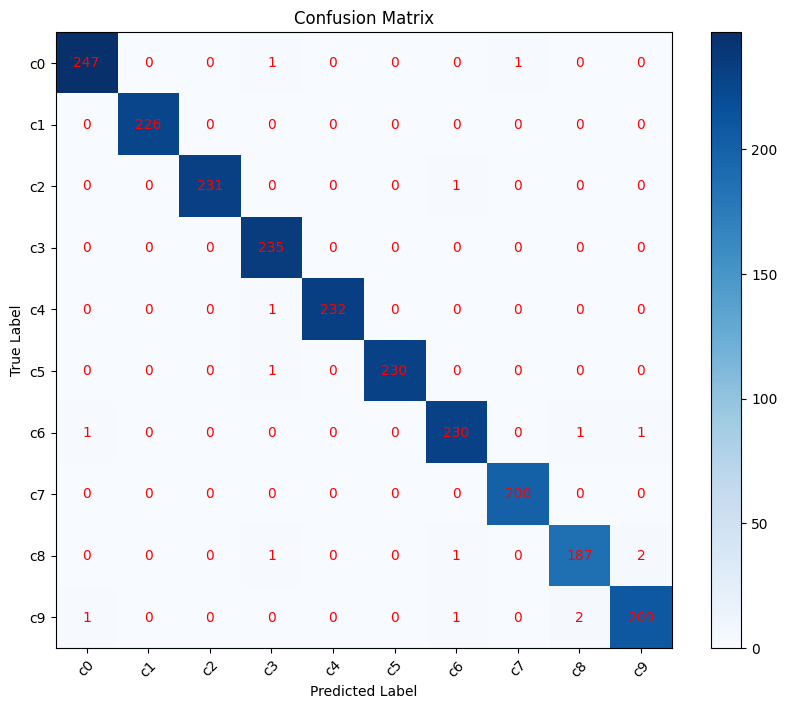

Total Misclassifications: 16


In [ ]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

# Save the model
model.save("state_farm_cnn_model.h5")

# Evaluate the model on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate the matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')

plt.show()

# Count misclassifications
misclassifications = np.sum(y_test != y_pred)
print(f"Total Misclassifications: {misclassifications}")

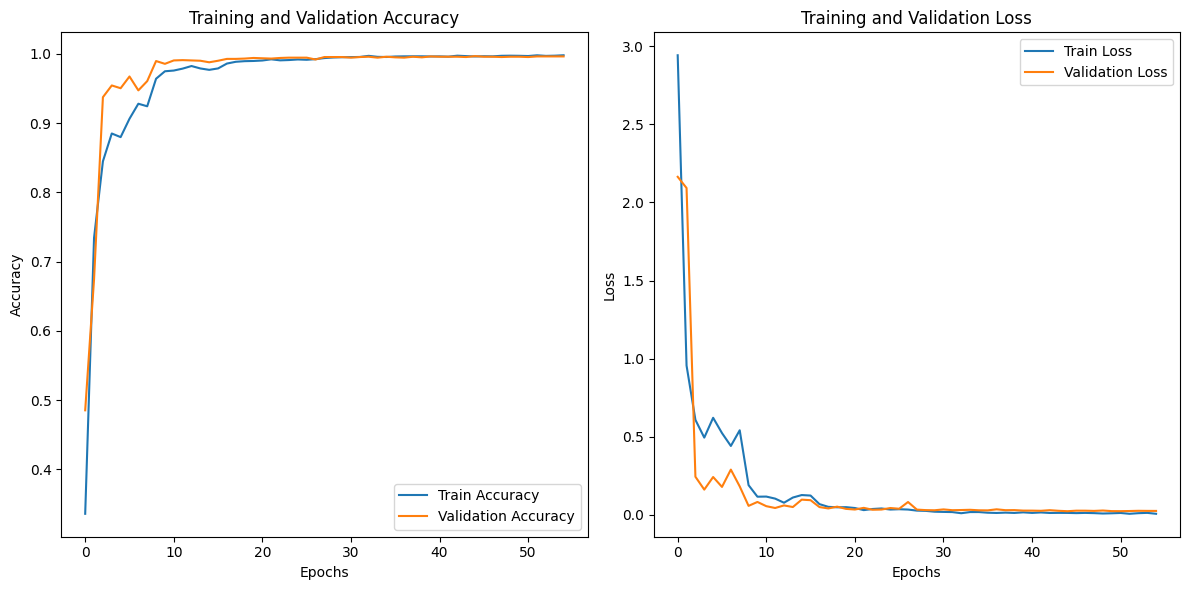

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0606
Test Accuracy: 0.9928666949272156
Test Loss: 0.05206567421555519
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

          c0       0.99      0.99      0.99       249
          c1       1.00      1.00      1.00       226
          c2       1.00      1.00      1.00       232
          c3       0.98      1.00      0.99       235
          c4       1.00      1.00      1.00       233
          c5       1.00      1.00      1.00       231
          c6       0.99      0.99      0.99       233
          c7       1.00      1.00      1.00       200
          c8       0.98      0.98      0.98       191
          c9       0.99      0.98      0.98       213

    accuracy                           0.99      2243
   macro avg       0.99      0.99      0.99      2243
weighted avg       0.99      0.99      0.99      2243



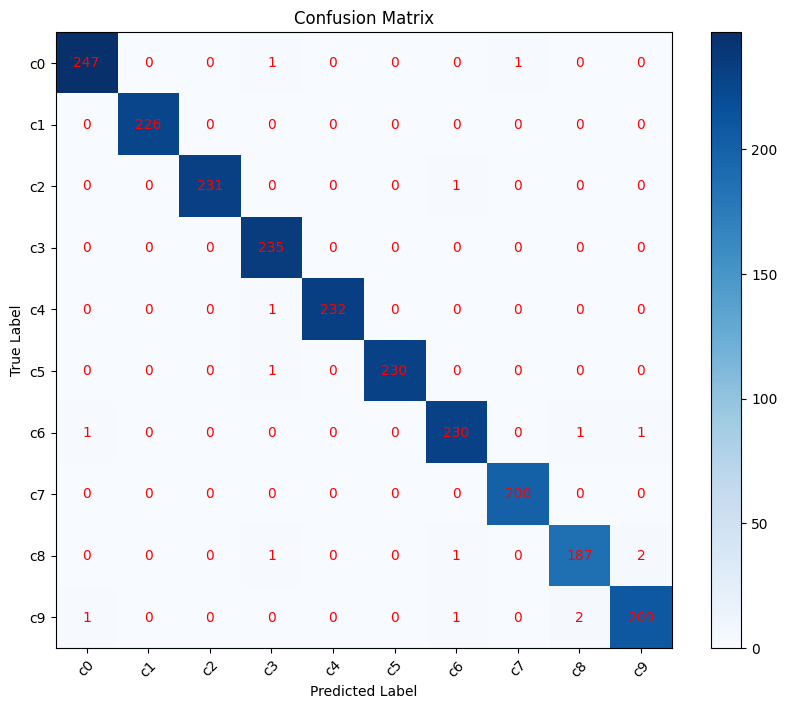

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Misclassifications on Train Set: 1 / 17939
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Misclassifications on Validation Set: 8 / 2242
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Misclassifications on Test Set: 16 / 2243


In [ ]:
# Get the training and validation accuracy, loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Get predictions for the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate the matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')

plt.show()
+++++++++++++++++++++++++++++++++
# Misclassifications on train set
y_train_pred = np.argmax(model.predict(x_train), axis=1)
train_misclassifications = np.sum(y_train != y_train_pred)
print(f"Misclassifications on Train Set: {train_misclassifications} / {len(y_train)}")

# Misclassifications on validation set
y_val_pred = np.argmax(model.predict(x_val), axis=1)
val_misclassifications = np.sum(y_val != y_val_pred)
print(f"Misclassifications on Validation Set: {val_misclassifications} / {len(y_val)}")

# Misclassifications on test set
y_test_pred = np.argmax(model.predict(x_test), axis=1)
test_misclassifications = np.sum(y_test != y_test_pred)
print(f"Misclassifications on Test Set: {test_misclassifications} / {len(y_test)}")